          T    N    Load
0       1.1  0.1  4582.0
1       1.1  0.3  4482.0
2       1.1  0.6  4421.0
3       0.9  0.9  4335.0
4       1.2  0.4  4304.0
...     ...  ...     ...
61363   0.9    0  4824.0
61364   0.2    0  4650.0
61365    -1    0  4573.0
61366  -1.8    0  4453.0
61367  -2.2    0  4389.0

[61368 rows x 3 columns]


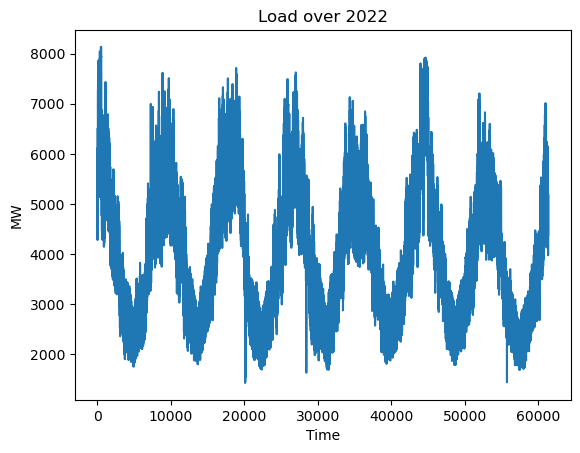

,T,N,Load
2016-01-01 00:00:00,1.1,0.1,4582.0
2016-01-01 01:00:00,1.1,0.3,4482.0
2016-01-01 02:00:00,1.1,0.6,4421.0
2016-01-01 03:00:00,0.9,0.9,4335.0
2016-01-01 04:00:00,1.2,0.4,4304.0
...,...,...,...
2022-12-31 19:00:00,0.9,0,4824.0
2022-12-31 20:00:00,0.2,0,4650.0
2022-12-31 21:00:00,-1,0,4573.0
2022-12-31 22:00:00,-1.8,0,4453.0


In [1]:
import pandas as pd 
import numpy as np

df = pd.read_csv('feature_dataframe.tsv',sep='\t')
df.replace(',', '.', regex=True, inplace=True)
#df = df.astype('float32')

new_columns = {'Lufttemperatur': 'T', 'Nedbør (1 t)': 'N','Actual Total Load [MW] - BZN|NO1': 'Load'}
df.rename(columns=new_columns, inplace=True)
df.drop(columns=['inflasjon'], inplace=True)
#df_year= df.tail(8760).reset_index(drop=True)
#print(len(df_year))
print(df)

import matplotlib.pyplot as plt
plt.plot(df.Load)
plt.xlabel("Time")
plt.ylabel("MW")
plt.title("Load over 2022")
plt.show()


start_date = '2016-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'
datetime_index = pd.date_range(start=start_date, end=end_date, freq='H')
df.set_index(datetime_index, inplace=True)
df
#df_year.set_index(datetime_index, inplace=True)
#df_year

In [2]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
     # Sort the DataFrame by the index
    df = df.sort_index()
    return df

df = create_features(df)
#df = df.loc['2022-06-01 00:00:00':'2022-12-31 23:00:00']

In [3]:
#Assuming df is your DataFrame
df.replace('-', pd.NA, inplace=True)  # Replace '-' with NaN

# Drop rows with non-numeric values
df = df.apply(pd.to_numeric, errors='coerce').dropna()

In [4]:
#Extract data for January, February, March, and December
desired_months = [1]
december_data = df[df.index.month.isin(desired_months)]

december_df = pd.DataFrame(december_data)

df = december_df.drop(['dayofyear', 'quarter', 'month'], axis=1)
print(len(df))
df

5208


,T,N,Load,hour,dayofweek,year,dayofmonth,weekofyear
2016-01-01 00:00:00,1.1,0.1,4582.0,0,4,2016,1,53
2016-01-01 01:00:00,1.1,0.3,4482.0,1,4,2016,1,53
2016-01-01 02:00:00,1.1,0.6,4421.0,2,4,2016,1,53
2016-01-01 03:00:00,0.9,0.9,4335.0,3,4,2016,1,53
2016-01-01 04:00:00,1.2,0.4,4304.0,4,4,2016,1,53
...,...,...,...,...,...,...,...,...
2022-01-31 19:00:00,-4.1,0.0,5966.0,19,0,2022,31,5
2022-01-31 20:00:00,-5.3,0.0,5918.0,20,0,2022,31,5
2022-01-31 21:00:00,-5.6,0.0,5805.0,21,0,2022,31,5
2022-01-31 22:00:00,-5.3,0.0,5528.0,22,0,2022,31,5


In [5]:
# Separate features (X) and target variable (y)
X, y = df.drop(columns=['Load']), df.Load.values.astype('float32')
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# Apply scaling
ss = StandardScaler()
mm = MinMaxScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [6]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)


week = 24*7

inputs = week
predicts= week

X_ss, y_mm = split_sequences(X_trans, y_trans, inputs, predicts)
len(X_ss)

4874

In [7]:
X_train = X_ss[:-(inputs+predicts)]
X_test = X_ss[-(inputs+predicts):]

y_train = y_mm[:-(inputs+predicts)]
y_test = y_mm[-(inputs+predicts):] 
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

import torch
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors =torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], inputs, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], inputs, 
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: (4538, 168, 7) (4538, 168)
Testing Shape: (336, 168, 7) (336, 168)
Training Shape: torch.Size([4538, 168, 7]) torch.Size([4538, 168])
Testing Shape: torch.Size([336, 168, 7]) torch.Size([336, 168])


In [8]:
from torch.utils.data import DataLoader,Dataset

batch_size = 16

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train_tensors_final, y_train_tensors)
test_dataset = TimeSeriesDataset(X_test_tensors_final, y_test_tensors)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader

In [9]:
import torch.nn as nn
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size (hours to predcit)
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size(features)
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc =  nn.Linear(hidden_size, num_classes) # fully connected 
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        out = self.fc(output[:, -1, :]) # output
    
        return out
    
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, x, y):
        return torch.sqrt(torch.nn.functional.mse_loss(x, y))
    

In [10]:
import time
def training_loop(n_epochs, lstm, optimiser, loss_fn, train_loader, test_loader, patience=5):
    best_test_loss = float('inf')
    consecutive_no_improvement = 0
    for batch_X_train, batch_y_train in train_loader:
        print(batch_X_train.shape)
        print(batch_y_train.shape)
        break
    
    for epoch in range(n_epochs):
        i=0
        for batch_X_train, batch_y_train in train_loader:
            i+=1
            lstm.train()
            outputs = lstm.forward(batch_X_train)
            optimiser.zero_grad()
            loss = loss_fn(outputs, batch_y_train)
            loss.backward()
            optimiser.step()
        # Evaluate on the test set
        lstm.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_X_test, batch_y_test in test_loader:
                test_preds = lstm(batch_X_test)
                test_loss += loss_fn(test_preds, batch_y_test).item()

        test_loss /= len(test_loader)  # Average test loss over all batches
        
        

        if epoch % 1 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss))

        # Early stopping logic
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if consecutive_no_improvement >= patience:
            print(f"Early stopping at epoch {epoch}. No improvement in test loss for {patience} consecutive epochs.")
            break


In [51]:
            
n_epochs = 50 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_tensors_final.shape[2] # number of features
hidden_size = 50 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = predicts # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              train_loader =train_loader,
              test_loader = test_loader
              )

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02191, test loss: 0.01896
Epoch: 1, train loss: 0.02872, test loss: 0.01365
Epoch: 2, train loss: 0.00995, test loss: 0.01593
Epoch: 3, train loss: 0.00922, test loss: 0.03163
Epoch: 4, train loss: 0.00864, test loss: 0.01393
Epoch: 5, train loss: 0.00924, test loss: 0.02740
Epoch: 6, train loss: 0.01435, test loss: 0.04453
Early stopping at epoch 6. No improvement in test loss for 5 consecutive epochs.


(4874, 168) (4874, 168)
4874


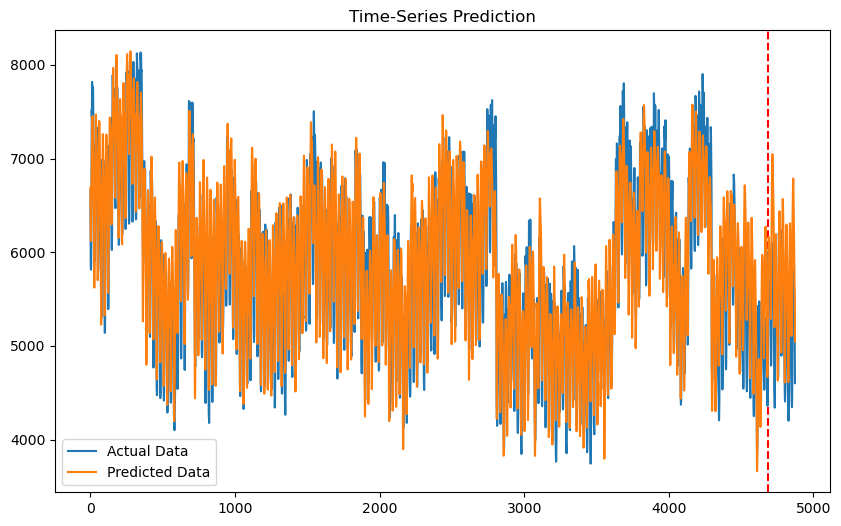

In [52]:
df_X_ss = ss.transform(df.drop(columns=['Load'])) # old transformers
df_y_mm = mm.transform(df.Load.values.reshape(-1, 1)) # old transformers


# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, week, week)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], week, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
print(data_predict.shape,dataY_plot.shape)
true, preds = [], []

for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set
print(len(true))
plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

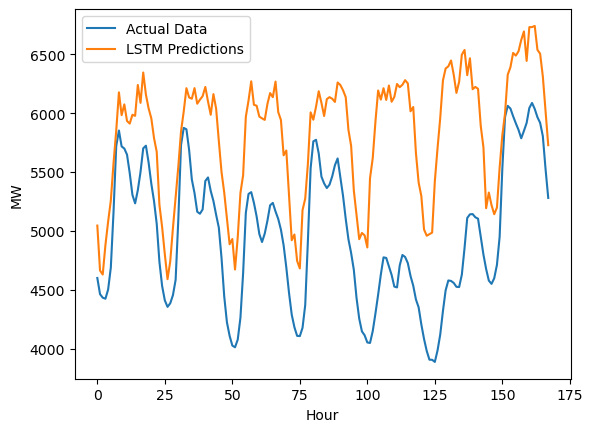

In [53]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.legend()
plt.xlabel("Hour")
plt.ylabel("MW")
plt.savefig("small_plot.png", dpi=300)
plt.show()

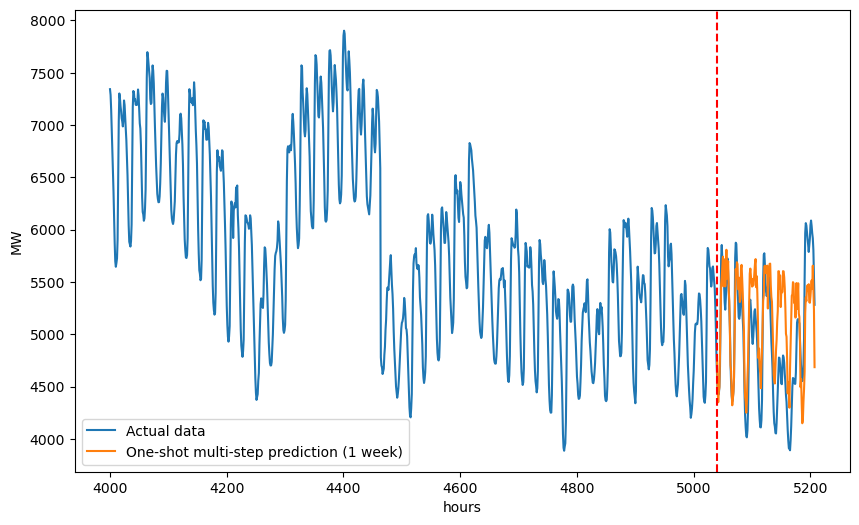

In [14]:
plt.figure(figsize=(10,6)) 
a = [x for x in range(4000, len(y))]
plt.plot(a, y[4000:], label='Actual data');
c = [x for x in range(len(y)-week, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (1 week)')
plt.axvline(x=len(y)-week, c='r', linestyle='--')
plt.ylabel("MW")
plt.xlabel("hours")
plt.legend()
plt.savefig("final_plot.png", dpi=300)
plt.show()

# checking learning rates and batch sizes

In [15]:
n_epochs = 20 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

batch_sizes = range(4,32,4)
etas = np.logspace(-6,-1,6)

hidden_size = 50 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

input_size = X_train_tensors_final.shape[2] # number of features
num_classes = predicts # number of output classes 
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
mse_train_list = np.zeros((len(batch_sizes), len(etas)))
rmse_train_list = np.zeros((len(batch_sizes), len(etas)))
mse_test_list = np.zeros((len(batch_sizes), len(etas)))
rmse_test_list = np.zeros((len(batch_sizes), len(etas)))
r2_train_list = np.zeros((len(batch_sizes), len(etas)))
r2_test_list = np.zeros((len(batch_sizes), len(etas)))

for i, batch_size in enumerate(batch_sizes):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    for j, learning_rate in enumerate(etas):
        
        lstm1 = LSTM(num_classes, 
                      input_size, 
                      hidden_size, 
                      num_layers)
        
        loss_fn = torch.nn.MSELoss()    
        optimiser = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

        training_loop(n_epochs=n_epochs,
                      lstm=lstm1,
                      optimiser=optimiser,
                      loss_fn=loss_fn,
                      train_loader=train_loader,
                      test_loader=test_loader
                      )
        
        train_predict = lstm1(df_X_ss)
        data_predict = train_predict.data.numpy()
        data_predict = mm.inverse_transform(data_predict)
        preds = []
        for z in range(len(data_predict)):
            preds.append(data_predict[z][0])

        test_predict = lstm1(X_test_tensors_final[-1].unsqueeze(0))
        test_predict = test_predict.detach().numpy()
        test_predict = mm.inverse_transform(test_predict)
        test_predict = test_predict[0].tolist()
        
        test_target = y_test_tensors[-1].detach().numpy() 
        test_target = mm.inverse_transform(test_target.reshape(1, -1))
        test_target = test_target[0].tolist()
        
        mse_train = mean_squared_error(true, preds)
        rmse_train = np.sqrt(mse_train)  
        r2_train = r2_score(true, preds)
        
        mse_test = mean_squared_error(test_target, test_predict)
        rmse_test = np.sqrt(mse_test)  
        r2_test = r2_score(test_target, test_predict)
        
        mse_train_list[i, j] = mse_train
        rmse_train_list[i, j] = rmse_train
        mse_test_list[i, j] = mse_test
        rmse_test_list[i, j] = rmse_test
        r2_train_list[i, j] = r2_train
        r2_test_list[i, j] = r2_test

torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.32228, test loss: 0.12522
Epoch: 1, train loss: 0.36777, test loss: 0.12336
Epoch: 2, train loss: 0.19167, test loss: 0.12150
Epoch: 3, train loss: 0.30732, test loss: 0.11964
Epoch: 4, train loss: 0.11496, test loss: 0.11774
Epoch: 5, train loss: 0.25290, test loss: 0.11580
Epoch: 6, train loss: 0.21439, test loss: 0.11379
Epoch: 7, train loss: 0.23550, test loss: 0.11170
Epoch: 8, train loss: 0.42147, test loss: 0.10952
Epoch: 9, train loss: 0.18359, test loss: 0.10721
Epoch: 10, train loss: 0.19858, test loss: 0.10478
Epoch: 11, train loss: 0.17180, test loss: 0.10219
Epoch: 12, train loss: 0.13920, test loss: 0.09945
Epoch: 13, train loss: 0.14560, test loss: 0.09652
Epoch: 14, train loss: 0.32860, test loss: 0.09337
Epoch: 15, train loss: 0.26877, test loss: 0.08999
Epoch: 16, train loss: 0.20075, test loss: 0.08635
Epoch: 17, train loss: 0.18726, test loss: 0.08240
Epoch: 18, train loss: 0.07358, test loss: 0.07

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.24592, test loss: 0.10929
Epoch: 1, train loss: 0.14232, test loss: 0.03911
Epoch: 2, train loss: 0.03823, test loss: 0.02638
Epoch: 3, train loss: 0.02176, test loss: 0.02439
Epoch: 4, train loss: 0.03256, test loss: 0.02565
Epoch: 5, train loss: 0.03089, test loss: 0.02455
Epoch: 6, train loss: 0.04728, test loss: 0.02424
Epoch: 7, train loss: 0.02422, test loss: 0.02378
Epoch: 8, train loss: 0.03693, test loss: 0.02344
Epoch: 9, train loss: 0.03382, test loss: 0.02163
Epoch: 10, train loss: 0.01940, test loss: 0.02193
Epoch: 11, train loss: 0.05509, test loss: 0.02127
Epoch: 12, train loss: 0.04023, test loss: 0.02147
Epoch: 13, train loss: 0.02536, test loss: 0.02054
Epoch: 14, train loss: 0.01735, test loss: 0.02039
Epoch: 15, train loss: 0.01919, test loss: 0.02118
Epoch: 16, train loss: 0.02182, test loss: 0.02091
Epoch: 17, train loss: 0.01832, test loss: 0.02031
Epoch: 18, train loss: 0.03627, test loss: 0.02

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.02901, test loss: 0.02242
Epoch: 1, train loss: 0.03809, test loss: 0.02147
Epoch: 2, train loss: 0.03485, test loss: 0.01500
Epoch: 3, train loss: 0.02131, test loss: 0.01948
Epoch: 4, train loss: 0.01444, test loss: 0.02105
Epoch: 5, train loss: 0.01019, test loss: 0.01556
Epoch: 6, train loss: 0.01956, test loss: 0.01383
Epoch: 7, train loss: 0.02637, test loss: 0.01470
Epoch: 8, train loss: 0.00764, test loss: 0.01151
Epoch: 9, train loss: 0.00686, test loss: 0.01135
Epoch: 10, train loss: 0.02293, test loss: 0.01196
Epoch: 11, train loss: 0.00727, test loss: 0.01224
Epoch: 12, train loss: 0.01462, test loss: 0.01262
Epoch: 13, train loss: 0.00777, test loss: 0.01595
Epoch: 14, train loss: 0.01764, test loss: 0.01368
Early stopping at epoch 14. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.03043, test loss: 0.01956
Epoch: 1, train loss: 0.02282, test loss: 0.01175
Epoch: 2, train loss: 0.01881, test loss: 0.02239
Epoch: 3, train loss: 0.00456, test loss: 0.01484
Epoch: 4, train loss: 0.00621, test loss: 0.01441
Epoch: 5, train loss: 0.00493, test loss: 0.01202
Epoch: 6, train loss: 0.00497, test loss: 0.01153
Epoch: 7, train loss: 0.00487, test loss: 0.01003
Epoch: 8, train loss: 0.00571, test loss: 0.01169
Epoch: 9, train loss: 0.00389, test loss: 0.01189
Epoch: 10, train loss: 0.00326, test loss: 0.01243
Epoch: 11, train loss: 0.00529, test loss: 0.01328
Epoch: 12, train loss: 0.00404, test loss: 0.01447
Early stopping at epoch 12. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.03965, test loss: 0.00873
Epoch: 1, train loss: 0.00577, test loss: 0.02502
Epoch: 2, train loss: 0.00653, test loss: 0.02048
Epoch: 3, train loss: 0.00288, test loss: 0.01303
Epoch: 4, train loss: 0.00304, test loss: 0.01490
Epoch: 5, train loss: 0.00441, test loss: 0.01375
Early stopping at epoch 5. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.01521, test loss: 0.04088
Epoch: 1, train loss: 0.01838, test loss: 0.03893
Epoch: 2, train loss: 0.02669, test loss: 0.05267
Epoch: 3, train loss: 0.03720, test loss: 0.02753
Epoch: 4, train loss: 0.04444, test loss: 0.05876
Epoch: 5, train loss: 0.06046, test loss: 0.03756
Epoch: 6, train loss: 0.04158, test loss: 0.02941
Epoch: 7, train loss: 0.01810, test loss: 0.04534
Epoch: 8, train loss: 0.03961, test loss: 0.05324
Early stopping at epoch 8. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.31066, test loss: 0.12908
Epoch: 1, train loss: 0.22257, test loss: 0.12798
Epoch: 2, train loss: 0.24556, test loss: 0.12688
Epoch: 3, train loss: 0.32966, test loss: 0.12577
Epoch: 4, train loss: 0.27299, test loss: 0.12465
Epoch: 5, train loss: 0.22093, test loss: 0.12351
Epoch: 6, train loss: 0.35924, test loss: 0.12235
Epoch: 7, train loss: 0.21021, test loss: 0.12116
Epoch: 8, train loss: 0.34689, test loss: 0.11994
Epoch: 9, train loss: 0.18329, test loss: 0.11868
Epoch: 10, train loss: 0.37482, test loss: 0.11739
Epoch: 11, train loss: 0.23797, test loss: 0.11605
Epoch: 12, train loss: 0.18287, test loss: 0.11467
Epoch: 13, train loss: 0.25115, test loss: 0.11324
Epoch: 14, train loss: 0.20316, test loss: 0.11177
Epoch: 15, train loss: 0.32125, test loss: 0.11024
Epoch: 16, train loss: 0.34224, test loss: 0.10865
Epoch: 17, train loss: 0.17015, test loss: 0.10701
Epoch: 18, train loss: 0.15911, test loss: 0.10

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.15175, test loss: 0.11181
Epoch: 1, train loss: 0.15607, test loss: 0.09628
Epoch: 2, train loss: 0.15149, test loss: 0.06503
Epoch: 3, train loss: 0.12133, test loss: 0.04579
Epoch: 4, train loss: 0.04259, test loss: 0.03669
Epoch: 5, train loss: 0.03210, test loss: 0.03178
Epoch: 6, train loss: 0.03277, test loss: 0.02830
Epoch: 7, train loss: 0.06167, test loss: 0.02602
Epoch: 8, train loss: 0.02859, test loss: 0.02367
Epoch: 9, train loss: 0.02014, test loss: 0.02188
Epoch: 10, train loss: 0.05331, test loss: 0.02240
Epoch: 11, train loss: 0.04757, test loss: 0.02174
Epoch: 12, train loss: 0.04345, test loss: 0.02158
Epoch: 13, train loss: 0.02414, test loss: 0.02116
Epoch: 14, train loss: 0.03321, test loss: 0.02083
Epoch: 15, train loss: 0.01869, test loss: 0.02018
Epoch: 16, train loss: 0.04130, test loss: 0.01999
Epoch: 17, train loss: 0.02541, test loss: 0.02071
Epoch: 18, train loss: 0.02837, test loss: 0.01

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.02845, test loss: 0.02609
Epoch: 1, train loss: 0.03675, test loss: 0.02106
Epoch: 2, train loss: 0.01839, test loss: 0.01964
Epoch: 3, train loss: 0.02084, test loss: 0.01687
Epoch: 4, train loss: 0.02219, test loss: 0.01648
Epoch: 5, train loss: 0.01862, test loss: 0.01648
Epoch: 6, train loss: 0.01294, test loss: 0.01585
Epoch: 7, train loss: 0.02460, test loss: 0.01363
Epoch: 8, train loss: 0.01085, test loss: 0.01290
Epoch: 9, train loss: 0.02488, test loss: 0.01378
Epoch: 10, train loss: 0.01552, test loss: 0.01472
Epoch: 11, train loss: 0.01207, test loss: 0.01397
Epoch: 12, train loss: 0.00902, test loss: 0.01403
Epoch: 13, train loss: 0.01463, test loss: 0.01344
Early stopping at epoch 13. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.01282, test loss: 0.01671
Epoch: 1, train loss: 0.02656, test loss: 0.01729
Epoch: 2, train loss: 0.02056, test loss: 0.01386
Epoch: 3, train loss: 0.01215, test loss: 0.01292
Epoch: 4, train loss: 0.00738, test loss: 0.00779
Epoch: 5, train loss: 0.00762, test loss: 0.01027
Epoch: 6, train loss: 0.00770, test loss: 0.00835
Epoch: 7, train loss: 0.01403, test loss: 0.01086
Epoch: 8, train loss: 0.00484, test loss: 0.03631
Epoch: 9, train loss: 0.00550, test loss: 0.01206
Early stopping at epoch 9. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.00947, test loss: 0.01873
Epoch: 1, train loss: 0.00959, test loss: 0.01670
Epoch: 2, train loss: 0.00490, test loss: 0.03066
Epoch: 3, train loss: 0.00654, test loss: 0.01466
Epoch: 4, train loss: 0.00407, test loss: 0.01370
Epoch: 5, train loss: 0.00265, test loss: 0.01472
Epoch: 6, train loss: 0.00276, test loss: 0.01557
Epoch: 7, train loss: 0.00369, test loss: 0.01835
Epoch: 8, train loss: 0.00258, test loss: 0.01673
Epoch: 9, train loss: 0.00360, test loss: 0.01707
Early stopping at epoch 9. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.01272, test loss: 0.02514
Epoch: 1, train loss: 0.00764, test loss: 0.04914
Epoch: 2, train loss: 0.00833, test loss: 0.05120
Epoch: 3, train loss: 0.01017, test loss: 0.05088
Epoch: 4, train loss: 0.03091, test loss: 0.10209
Epoch: 5, train loss: 0.02593, test loss: 0.05300
Early stopping at epoch 5. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.20416, test loss: 0.11671
Epoch: 1, train loss: 0.12125, test loss: 0.11606
Epoch: 2, train loss: 0.23353, test loss: 0.11540
Epoch: 3, train loss: 0.16489, test loss: 0.11474
Epoch: 4, train loss: 0.24428, test loss: 0.11408
Epoch: 5, train loss: 0.24579, test loss: 0.11341
Epoch: 6, train loss: 0.27390, test loss: 0.11274
Epoch: 7, train loss: 0.40869, test loss: 0.11206
Epoch: 8, train loss: 0.16730, test loss: 0.11138
Epoch: 9, train loss: 0.18131, test loss: 0.11068
Epoch: 10, train loss: 0.34565, test loss: 0.10998
Epoch: 11, train loss: 0.18559, test loss: 0.10927
Epoch: 12, train loss: 0.51735, test loss: 0.10854
Epoch: 13, train loss: 0.25171, test loss: 0.10781
Epoch: 14, train loss: 0.27948, test loss: 0.10706
Epoch: 15, train loss: 0.50873, test loss: 0.10629
Epoch: 16, train loss: 0.15300, test loss: 0.10552
Epoch: 17, train loss: 0.30140, test loss: 0.10473
Epoch: 18, train loss: 0.13839, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.41284, test loss: 0.12007
Epoch: 1, train loss: 0.18999, test loss: 0.11260
Epoch: 2, train loss: 0.25562, test loss: 0.10204
Epoch: 3, train loss: 0.21128, test loss: 0.08247
Epoch: 4, train loss: 0.13678, test loss: 0.03877
Epoch: 5, train loss: 0.04481, test loss: 0.03381
Epoch: 6, train loss: 0.03421, test loss: 0.03052
Epoch: 7, train loss: 0.04755, test loss: 0.02912
Epoch: 8, train loss: 0.02724, test loss: 0.02776
Epoch: 9, train loss: 0.03791, test loss: 0.02725
Epoch: 10, train loss: 0.03280, test loss: 0.02680
Epoch: 11, train loss: 0.02593, test loss: 0.02594
Epoch: 12, train loss: 0.02186, test loss: 0.02565
Epoch: 13, train loss: 0.03007, test loss: 0.02449
Epoch: 14, train loss: 0.03405, test loss: 0.02358
Epoch: 15, train loss: 0.02771, test loss: 0.02416
Epoch: 16, train loss: 0.03475, test loss: 0.02376
Epoch: 17, train loss: 0.03778, test loss: 0.02335
Epoch: 18, train loss: 0.02966, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.02952, test loss: 0.02299
Epoch: 1, train loss: 0.03221, test loss: 0.02263
Epoch: 2, train loss: 0.04161, test loss: 0.02167
Epoch: 3, train loss: 0.04077, test loss: 0.02111
Epoch: 4, train loss: 0.01785, test loss: 0.01707
Epoch: 5, train loss: 0.02370, test loss: 0.01947
Epoch: 6, train loss: 0.01483, test loss: 0.01638
Epoch: 7, train loss: 0.01343, test loss: 0.01471
Epoch: 8, train loss: 0.00950, test loss: 0.01427
Epoch: 9, train loss: 0.02009, test loss: 0.01469
Epoch: 10, train loss: 0.01366, test loss: 0.01524
Epoch: 11, train loss: 0.01727, test loss: 0.01416
Epoch: 12, train loss: 0.01473, test loss: 0.02017
Epoch: 13, train loss: 0.02141, test loss: 0.02118
Epoch: 14, train loss: 0.01323, test loss: 0.02513
Epoch: 15, train loss: 0.00982, test loss: 0.02495
Epoch: 16, train loss: 0.00934, test loss: 0.02381
Early stopping at epoch 16. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.01727, test loss: 0.01510
Epoch: 1, train loss: 0.01661, test loss: 0.02257
Epoch: 2, train loss: 0.01406, test loss: 0.01640
Epoch: 3, train loss: 0.00968, test loss: 0.00767
Epoch: 4, train loss: 0.00829, test loss: 0.01198
Epoch: 5, train loss: 0.00577, test loss: 0.00686
Epoch: 6, train loss: 0.01036, test loss: 0.00666
Epoch: 7, train loss: 0.00826, test loss: 0.00850
Epoch: 8, train loss: 0.00363, test loss: 0.01977
Epoch: 9, train loss: 0.00561, test loss: 0.00747
Epoch: 10, train loss: 0.00485, test loss: 0.01227
Epoch: 11, train loss: 0.00359, test loss: 0.01407
Early stopping at epoch 11. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.01326, test loss: 0.03948
Epoch: 1, train loss: 0.01382, test loss: 0.01781
Epoch: 2, train loss: 0.00968, test loss: 0.03153
Epoch: 3, train loss: 0.00396, test loss: 0.02319
Epoch: 4, train loss: 0.00379, test loss: 0.02301
Epoch: 5, train loss: 0.00280, test loss: 0.02215
Epoch: 6, train loss: 0.00388, test loss: 0.02310
Early stopping at epoch 6. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.01173, test loss: 0.02014
Epoch: 1, train loss: 0.01992, test loss: 0.01317
Epoch: 2, train loss: 0.01138, test loss: 0.06295
Epoch: 3, train loss: 0.01035, test loss: 0.02119
Epoch: 4, train loss: 0.01106, test loss: 0.03873
Epoch: 5, train loss: 0.02617, test loss: 0.09096
Epoch: 6, train loss: 0.00783, test loss: 0.06723
Early stopping at epoch 6. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.28769, test loss: 0.12103
Epoch: 1, train loss: 0.28050, test loss: 0.12038
Epoch: 2, train loss: 0.26485, test loss: 0.11973
Epoch: 3, train loss: 0.19450, test loss: 0.11908
Epoch: 4, train loss: 0.31936, test loss: 0.11843
Epoch: 5, train loss: 0.33869, test loss: 0.11779
Epoch: 6, train loss: 0.21221, test loss: 0.11715
Epoch: 7, train loss: 0.29285, test loss: 0.11651
Epoch: 8, train loss: 0.18309, test loss: 0.11587
Epoch: 9, train loss: 0.30122, test loss: 0.11523
Epoch: 10, train loss: 0.23568, test loss: 0.11459
Epoch: 11, train loss: 0.25644, test loss: 0.11395
Epoch: 12, train loss: 0.24529, test loss: 0.11330
Epoch: 13, train loss: 0.23816, test loss: 0.11265
Epoch: 14, train loss: 0.27182, test loss: 0.11201
Epoch: 15, train loss: 0.26791, test loss: 0.11135
Epoch: 16, train loss: 0.23371, test loss: 0.11069
Epoch: 17, train loss: 0.19943, test loss: 0.11003
Epoch: 18, train loss: 0.22609, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.22165, test loss: 0.12108
Epoch: 1, train loss: 0.21129, test loss: 0.11560
Epoch: 2, train loss: 0.27765, test loss: 0.10853
Epoch: 3, train loss: 0.21617, test loss: 0.09808
Epoch: 4, train loss: 0.19730, test loss: 0.07919
Epoch: 5, train loss: 0.09413, test loss: 0.04342
Epoch: 6, train loss: 0.07636, test loss: 0.03680
Epoch: 7, train loss: 0.06918, test loss: 0.03274
Epoch: 8, train loss: 0.04494, test loss: 0.03137
Epoch: 9, train loss: 0.04809, test loss: 0.02990
Epoch: 10, train loss: 0.04182, test loss: 0.02928
Epoch: 11, train loss: 0.03176, test loss: 0.02882
Epoch: 12, train loss: 0.03593, test loss: 0.02871
Epoch: 13, train loss: 0.03824, test loss: 0.02844
Epoch: 14, train loss: 0.03168, test loss: 0.02751
Epoch: 15, train loss: 0.04654, test loss: 0.02670
Epoch: 16, train loss: 0.03338, test loss: 0.02650
Epoch: 17, train loss: 0.04174, test loss: 0.02643
Epoch: 18, train loss: 0.03823, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.04065, test loss: 0.02957
Epoch: 1, train loss: 0.03119, test loss: 0.02528
Epoch: 2, train loss: 0.02680, test loss: 0.02233
Epoch: 3, train loss: 0.03252, test loss: 0.02091
Epoch: 4, train loss: 0.03202, test loss: 0.02073
Epoch: 5, train loss: 0.03013, test loss: 0.01995
Epoch: 6, train loss: 0.02488, test loss: 0.01950
Epoch: 7, train loss: 0.02429, test loss: 0.01872
Epoch: 8, train loss: 0.02382, test loss: 0.01821
Epoch: 9, train loss: 0.01854, test loss: 0.02080
Epoch: 10, train loss: 0.02048, test loss: 0.02343
Epoch: 11, train loss: 0.02291, test loss: 0.01498
Epoch: 12, train loss: 0.02266, test loss: 0.01447
Epoch: 13, train loss: 0.01255, test loss: 0.01378
Epoch: 14, train loss: 0.01782, test loss: 0.01941
Epoch: 15, train loss: 0.02130, test loss: 0.01668
Epoch: 16, train loss: 0.01867, test loss: 0.01681
Epoch: 17, train loss: 0.01521, test loss: 0.01812
Epoch: 18, train loss: 0.01320, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.02663, test loss: 0.02768
Epoch: 1, train loss: 0.01571, test loss: 0.02227
Epoch: 2, train loss: 0.01305, test loss: 0.01691
Epoch: 3, train loss: 0.01165, test loss: 0.05205
Epoch: 4, train loss: 0.01118, test loss: 0.04675
Epoch: 5, train loss: 0.00969, test loss: 0.05452
Epoch: 6, train loss: 0.00879, test loss: 0.05083
Epoch: 7, train loss: 0.00932, test loss: 0.04911
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.02577, test loss: 0.01433
Epoch: 1, train loss: 0.02163, test loss: 0.04565
Epoch: 2, train loss: 0.00734, test loss: 0.00950
Epoch: 3, train loss: 0.01571, test loss: 0.03037
Epoch: 4, train loss: 0.00542, test loss: 0.04710
Epoch: 5, train loss: 0.00483, test loss: 0.05526
Epoch: 6, train loss: 0.00468, test loss: 0.05053
Epoch: 7, train loss: 0.00356, test loss: 0.06157
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.01323, test loss: 0.03439
Epoch: 1, train loss: 0.01805, test loss: 0.01974
Epoch: 2, train loss: 0.01187, test loss: 0.07090
Epoch: 3, train loss: 0.01172, test loss: 0.02167
Epoch: 4, train loss: 0.01935, test loss: 0.03812
Epoch: 5, train loss: 0.01491, test loss: 0.05301
Epoch: 6, train loss: 0.01105, test loss: 0.05321
Early stopping at epoch 6. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.25150, test loss: 0.12011
Epoch: 1, train loss: 0.26211, test loss: 0.11955
Epoch: 2, train loss: 0.31613, test loss: 0.11899
Epoch: 3, train loss: 0.27120, test loss: 0.11844
Epoch: 4, train loss: 0.28863, test loss: 0.11788
Epoch: 5, train loss: 0.31464, test loss: 0.11732
Epoch: 6, train loss: 0.25221, test loss: 0.11676
Epoch: 7, train loss: 0.24819, test loss: 0.11621
Epoch: 8, train loss: 0.27613, test loss: 0.11564
Epoch: 9, train loss: 0.24315, test loss: 0.11508
Epoch: 10, train loss: 0.35162, test loss: 0.11452
Epoch: 11, train loss: 0.25541, test loss: 0.11396
Epoch: 12, train loss: 0.25602, test loss: 0.11339
Epoch: 13, train loss: 0.23767, test loss: 0.11282
Epoch: 14, train loss: 0.28067, test loss: 0.11225
Epoch: 15, train loss: 0.22350, test loss: 0.11168
Epoch: 16, train loss: 0.24378, test loss: 0.11110
Epoch: 17, train loss: 0.26240, test loss: 0.11052
Epoch: 18, train loss: 0.28408, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.25872, test loss: 0.12527
Epoch: 1, train loss: 0.30701, test loss: 0.11873
Epoch: 2, train loss: 0.21607, test loss: 0.11142
Epoch: 3, train loss: 0.19076, test loss: 0.10267
Epoch: 4, train loss: 0.18739, test loss: 0.09112
Epoch: 5, train loss: 0.16088, test loss: 0.07373
Epoch: 6, train loss: 0.10848, test loss: 0.04790
Epoch: 7, train loss: 0.05965, test loss: 0.04386
Epoch: 8, train loss: 0.06975, test loss: 0.03869
Epoch: 9, train loss: 0.04965, test loss: 0.03492
Epoch: 10, train loss: 0.03484, test loss: 0.03208
Epoch: 11, train loss: 0.04050, test loss: 0.02933
Epoch: 12, train loss: 0.03115, test loss: 0.02768
Epoch: 13, train loss: 0.03431, test loss: 0.02669
Epoch: 14, train loss: 0.04160, test loss: 0.02678
Epoch: 15, train loss: 0.03810, test loss: 0.02572
Epoch: 16, train loss: 0.03852, test loss: 0.02561
Epoch: 17, train loss: 0.03575, test loss: 0.02565
Epoch: 18, train loss: 0.03788, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.05514, test loss: 0.03256
Epoch: 1, train loss: 0.03729, test loss: 0.02605
Epoch: 2, train loss: 0.03691, test loss: 0.02272
Epoch: 3, train loss: 0.02946, test loss: 0.02340
Epoch: 4, train loss: 0.02451, test loss: 0.02137
Epoch: 5, train loss: 0.02590, test loss: 0.02044
Epoch: 6, train loss: 0.02225, test loss: 0.01895
Epoch: 7, train loss: 0.02694, test loss: 0.01969
Epoch: 8, train loss: 0.02300, test loss: 0.01774
Epoch: 9, train loss: 0.02050, test loss: 0.01840
Epoch: 10, train loss: 0.01664, test loss: 0.01711
Epoch: 11, train loss: 0.01284, test loss: 0.01336
Epoch: 12, train loss: 0.01448, test loss: 0.01414
Epoch: 13, train loss: 0.01647, test loss: 0.01305
Epoch: 14, train loss: 0.01334, test loss: 0.01444
Epoch: 15, train loss: 0.01492, test loss: 0.01513
Epoch: 16, train loss: 0.01536, test loss: 0.01590
Epoch: 17, train loss: 0.01633, test loss: 0.01825
Epoch: 18, train loss: 0.01301, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.02702, test loss: 0.02338
Epoch: 1, train loss: 0.01826, test loss: 0.01991
Epoch: 2, train loss: 0.01468, test loss: 0.01917
Epoch: 3, train loss: 0.01808, test loss: 0.01350
Epoch: 4, train loss: 0.01135, test loss: 0.01424
Epoch: 5, train loss: 0.00872, test loss: 0.01216
Epoch: 6, train loss: 0.00886, test loss: 0.01259
Epoch: 7, train loss: 0.02397, test loss: 0.01402
Epoch: 8, train loss: 0.00660, test loss: 0.01106
Epoch: 9, train loss: 0.00672, test loss: 0.01174
Epoch: 10, train loss: 0.00814, test loss: 0.01280
Epoch: 11, train loss: 0.00941, test loss: 0.03960
Epoch: 12, train loss: 0.00745, test loss: 0.01229
Epoch: 13, train loss: 0.00647, test loss: 0.01224
Early stopping at epoch 13. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.01608, test loss: 0.01857
Epoch: 1, train loss: 0.01347, test loss: 0.04146
Epoch: 2, train loss: 0.00839, test loss: 0.05674
Epoch: 3, train loss: 0.00658, test loss: 0.02424
Epoch: 4, train loss: 0.00591, test loss: 0.02528
Epoch: 5, train loss: 0.00539, test loss: 0.06751
Early stopping at epoch 5. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.01762, test loss: 0.02975
Epoch: 1, train loss: 0.01514, test loss: 0.05064
Epoch: 2, train loss: 0.00829, test loss: 0.01907
Epoch: 3, train loss: 0.00885, test loss: 0.02369
Epoch: 4, train loss: 0.01073, test loss: 0.02046
Epoch: 5, train loss: 0.00888, test loss: 0.01670
Epoch: 6, train loss: 0.00887, test loss: 0.04107
Epoch: 7, train loss: 0.00765, test loss: 0.05525
Epoch: 8, train loss: 0.01136, test loss: 0.03389
Epoch: 9, train loss: 0.03001, test loss: 0.04669
Epoch: 10, train loss: 0.01094, test loss: 0.02825
Early stopping at epoch 10. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.43951, test loss: 0.12091
Epoch: 1, train loss: 0.23160, test loss: 0.12057
Epoch: 2, train loss: 0.33994, test loss: 0.12023
Epoch: 3, train loss: 0.49262, test loss: 0.11990
Epoch: 4, train loss: 0.11054, test loss: 0.11956
Epoch: 5, train loss: 0.21660, test loss: 0.11923
Epoch: 6, train loss: 0.24663, test loss: 0.11889
Epoch: 7, train loss: 0.28304, test loss: 0.11856
Epoch: 8, train loss: 0.24978, test loss: 0.11822
Epoch: 9, train loss: 0.23132, test loss: 0.11789
Epoch: 10, train loss: 0.19125, test loss: 0.11756
Epoch: 11, train loss: 0.26808, test loss: 0.11723
Epoch: 12, train loss: 0.19561, test loss: 0.11690
Epoch: 13, train loss: 0.27042, test loss: 0.11656
Epoch: 14, train loss: 0.13947, test loss: 0.11623
Epoch: 15, train loss: 0.30591, test loss: 0.11589
Epoch: 16, train loss: 0.20286, test loss: 0.11555
Epoch: 17, train loss: 0.19739, test loss: 0.11522
Epoch: 18, train loss: 0.32876, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.12536, test loss: 0.12821
Epoch: 1, train loss: 0.39400, test loss: 0.12500
Epoch: 2, train loss: 0.16224, test loss: 0.12163
Epoch: 3, train loss: 0.24635, test loss: 0.11788
Epoch: 4, train loss: 0.17665, test loss: 0.11351
Epoch: 5, train loss: 0.25640, test loss: 0.10816
Epoch: 6, train loss: 0.26213, test loss: 0.10085
Epoch: 7, train loss: 0.08814, test loss: 0.08905
Epoch: 8, train loss: 0.08772, test loss: 0.06560
Epoch: 9, train loss: 0.10261, test loss: 0.04169
Epoch: 10, train loss: 0.04771, test loss: 0.03170
Epoch: 11, train loss: 0.05302, test loss: 0.02884
Epoch: 12, train loss: 0.04637, test loss: 0.02826
Epoch: 13, train loss: 0.05733, test loss: 0.02770
Epoch: 14, train loss: 0.05099, test loss: 0.02731
Epoch: 15, train loss: 0.03748, test loss: 0.02666
Epoch: 16, train loss: 0.05700, test loss: 0.02652
Epoch: 17, train loss: 0.02578, test loss: 0.02619
Epoch: 18, train loss: 0.06785, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.06077, test loss: 0.04600
Epoch: 1, train loss: 0.03203, test loss: 0.02988
Epoch: 2, train loss: 0.03683, test loss: 0.02615
Epoch: 3, train loss: 0.03853, test loss: 0.02623
Epoch: 4, train loss: 0.03356, test loss: 0.02557
Epoch: 5, train loss: 0.02744, test loss: 0.02106
Epoch: 6, train loss: 0.01876, test loss: 0.02161
Epoch: 7, train loss: 0.02833, test loss: 0.02273
Epoch: 8, train loss: 0.03301, test loss: 0.02211
Epoch: 9, train loss: 0.02351, test loss: 0.01906
Epoch: 10, train loss: 0.02402, test loss: 0.02417
Epoch: 11, train loss: 0.02126, test loss: 0.02069
Epoch: 12, train loss: 0.03013, test loss: 0.01629
Epoch: 13, train loss: 0.01476, test loss: 0.01569
Epoch: 14, train loss: 0.01083, test loss: 0.01753
Epoch: 15, train loss: 0.01523, test loss: 0.01614
Epoch: 16, train loss: 0.02451, test loss: 0.01693
Epoch: 17, train loss: 0.01423, test loss: 0.01750
Epoch: 18, train loss: 0.00735, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01810, test loss: 0.02186
Epoch: 1, train loss: 0.02488, test loss: 0.02614
Epoch: 2, train loss: 0.02327, test loss: 0.01768
Epoch: 3, train loss: 0.02578, test loss: 0.02559
Epoch: 4, train loss: 0.01195, test loss: 0.04219
Epoch: 5, train loss: 0.01715, test loss: 0.03035
Epoch: 6, train loss: 0.00742, test loss: 0.01592
Epoch: 7, train loss: 0.01012, test loss: 0.01310
Epoch: 8, train loss: 0.01512, test loss: 0.01383
Epoch: 9, train loss: 0.00701, test loss: 0.01236
Epoch: 10, train loss: 0.00879, test loss: 0.01261
Epoch: 11, train loss: 0.00699, test loss: 0.01090
Epoch: 12, train loss: 0.00476, test loss: 0.01081
Epoch: 13, train loss: 0.01307, test loss: 0.01182
Epoch: 14, train loss: 0.00578, test loss: 0.01004
Epoch: 15, train loss: 0.00319, test loss: 0.00957
Epoch: 16, train loss: 0.01211, test loss: 0.00972
Epoch: 17, train loss: 0.00696, test loss: 0.00931
Epoch: 18, train loss: 0.00652, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02055, test loss: 0.02604
Epoch: 1, train loss: 0.00997, test loss: 0.01127
Epoch: 2, train loss: 0.00600, test loss: 0.00800
Epoch: 3, train loss: 0.00364, test loss: 0.01187
Epoch: 4, train loss: 0.00842, test loss: 0.02726
Epoch: 5, train loss: 0.00791, test loss: 0.04937
Epoch: 6, train loss: 0.00368, test loss: 0.01516
Epoch: 7, train loss: 0.00363, test loss: 0.01630
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01540, test loss: 0.07676
Epoch: 1, train loss: 0.04031, test loss: 0.10692
Epoch: 2, train loss: 0.00516, test loss: 0.05827
Epoch: 3, train loss: 0.00738, test loss: 0.12630
Epoch: 4, train loss: 0.01074, test loss: 0.07292
Epoch: 5, train loss: 0.01033, test loss: 0.05404
Epoch: 6, train loss: 0.00485, test loss: 0.03888
Epoch: 7, train loss: 0.00564, test loss: 0.04360
Epoch: 8, train loss: 0.00558, test loss: 0.06340
Epoch: 9, train loss: 0.00970, test loss: 0.07715
Epoch: 10, train loss: 0.00601, test loss: 0.05419
Epoch: 11, train loss: 0.00688, test loss: 0.05252
Early stopping at epoch 11. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.39187, test loss: 0.12192
Epoch: 1, train loss: 0.33679, test loss: 0.12160
Epoch: 2, train loss: 0.30047, test loss: 0.12128
Epoch: 3, train loss: 0.34464, test loss: 0.12097
Epoch: 4, train loss: 0.17039, test loss: 0.12065
Epoch: 5, train loss: 0.14412, test loss: 0.12033
Epoch: 6, train loss: 0.30239, test loss: 0.12002
Epoch: 7, train loss: 0.22106, test loss: 0.11970
Epoch: 8, train loss: 0.32124, test loss: 0.11938
Epoch: 9, train loss: 0.29488, test loss: 0.11907
Epoch: 10, train loss: 0.45700, test loss: 0.11875
Epoch: 11, train loss: 0.26655, test loss: 0.11843
Epoch: 12, train loss: 0.27679, test loss: 0.11811
Epoch: 13, train loss: 0.25376, test loss: 0.11780
Epoch: 14, train loss: 0.24285, test loss: 0.11747
Epoch: 15, train loss: 0.34156, test loss: 0.11716
Epoch: 16, train loss: 0.25273, test loss: 0.11684
Epoch: 17, train loss: 0.35476, test loss: 0.11651
Epoch: 18, train loss: 0.33160, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.28283, test loss: 0.12317
Epoch: 1, train loss: 0.35209, test loss: 0.11896
Epoch: 2, train loss: 0.21542, test loss: 0.11441
Epoch: 3, train loss: 0.27496, test loss: 0.10924
Epoch: 4, train loss: 0.23230, test loss: 0.10303
Epoch: 5, train loss: 0.25049, test loss: 0.09529
Epoch: 6, train loss: 0.15786, test loss: 0.08493
Epoch: 7, train loss: 0.08828, test loss: 0.06953
Epoch: 8, train loss: 0.06798, test loss: 0.04842
Epoch: 9, train loss: 0.09903, test loss: 0.04370
Epoch: 10, train loss: 0.09242, test loss: 0.04089
Epoch: 11, train loss: 0.04041, test loss: 0.03816
Epoch: 12, train loss: 0.03433, test loss: 0.03605
Epoch: 13, train loss: 0.05376, test loss: 0.03434
Epoch: 14, train loss: 0.04213, test loss: 0.03299
Epoch: 15, train loss: 0.02486, test loss: 0.03231
Epoch: 16, train loss: 0.04091, test loss: 0.03111
Epoch: 17, train loss: 0.02763, test loss: 0.03084
Epoch: 18, train loss: 0.03456, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.13991, test loss: 0.06713
Epoch: 1, train loss: 0.06282, test loss: 0.02786
Epoch: 2, train loss: 0.02644, test loss: 0.02567
Epoch: 3, train loss: 0.04074, test loss: 0.02632
Epoch: 4, train loss: 0.04792, test loss: 0.02493
Epoch: 5, train loss: 0.02023, test loss: 0.02363
Epoch: 6, train loss: 0.04296, test loss: 0.02232
Epoch: 7, train loss: 0.02392, test loss: 0.02164
Epoch: 8, train loss: 0.02537, test loss: 0.01893
Epoch: 9, train loss: 0.03106, test loss: 0.02209
Epoch: 10, train loss: 0.03860, test loss: 0.01744
Epoch: 11, train loss: 0.01938, test loss: 0.01765
Epoch: 12, train loss: 0.01496, test loss: 0.01646
Epoch: 13, train loss: 0.03003, test loss: 0.01566
Epoch: 14, train loss: 0.02024, test loss: 0.01354
Epoch: 15, train loss: 0.01553, test loss: 0.01623
Epoch: 16, train loss: 0.01246, test loss: 0.01720
Epoch: 17, train loss: 0.00893, test loss: 0.02407
Epoch: 18, train loss: 0.03441, test loss: 0.

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.02015, test loss: 0.01852
Epoch: 1, train loss: 0.01298, test loss: 0.01636
Epoch: 2, train loss: 0.01962, test loss: 0.01445
Epoch: 3, train loss: 0.03273, test loss: 0.02203
Epoch: 4, train loss: 0.01924, test loss: 0.04025
Epoch: 5, train loss: 0.00951, test loss: 0.05875
Epoch: 6, train loss: 0.00752, test loss: 0.07379
Epoch: 7, train loss: 0.00698, test loss: 0.06062
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.02491, test loss: 0.04829
Epoch: 1, train loss: 0.01576, test loss: 0.05293
Epoch: 2, train loss: 0.00707, test loss: 0.01412
Epoch: 3, train loss: 0.00585, test loss: 0.01151
Epoch: 4, train loss: 0.00713, test loss: 0.01434
Epoch: 5, train loss: 0.00554, test loss: 0.02422
Epoch: 6, train loss: 0.00566, test loss: 0.03467
Epoch: 7, train loss: 0.00225, test loss: 0.03751
Epoch: 8, train loss: 0.00163, test loss: 0.03707
Early stopping at epoch 8. No improvement in test loss for 5 consecutive epochs.


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.01793, test loss: 0.03894
Epoch: 1, train loss: 0.00676, test loss: 0.03293
Epoch: 2, train loss: 0.01121, test loss: 0.01777
Epoch: 3, train loss: 0.00796, test loss: 0.01719
Epoch: 4, train loss: 0.00738, test loss: 0.01520
Epoch: 5, train loss: 0.00652, test loss: 0.01487
Epoch: 6, train loss: 0.01485, test loss: 0.01639
Epoch: 7, train loss: 0.00829, test loss: 0.03200
Epoch: 8, train loss: 0.00719, test loss: 0.05135
Epoch: 9, train loss: 0.00803, test loss: 0.04597
Epoch: 10, train loss: 0.00538, test loss: 0.04830
Early stopping at epoch 10. No improvement in test loss for 5 consecutive epochs.


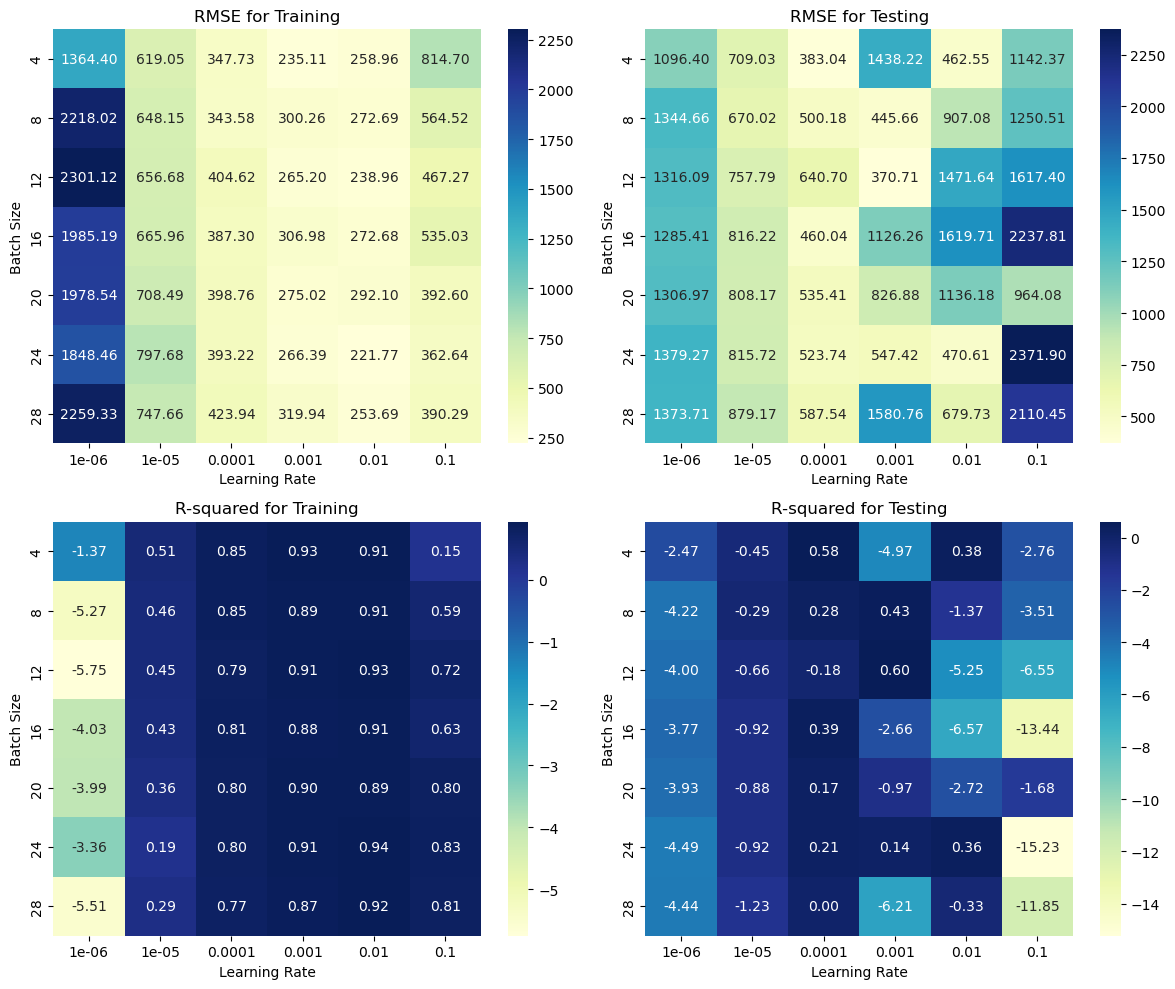

In [18]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

fmt_str = ".2f"

# Plot rmse for training
sns.heatmap(rmse_train_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('RMSE for Training')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Batch Size')
axes[0].set_xticks([i + 0.5 for i in range(len(etas))])
axes[0].set_yticks([i + 0.5 for i in range(len(batch_sizes))])
axes[0].set_xticklabels(etas)
axes[0].set_yticklabels(batch_sizes)

# Plot rmse for testing
sns.heatmap(rmse_test_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[1])
axes[1].set_title('RMSE for Testing')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Batch Size')
axes[1].set_xticks([i + 0.5 for i in range(len(etas))])
axes[1].set_yticks([i + 0.5 for i in range(len(batch_sizes))])
axes[1].set_xticklabels(etas)
axes[1].set_yticklabels(batch_sizes)

# Plot R2 for training
sns.heatmap(r2_train_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[2])
axes[2].set_title('R-squared for Training')
axes[2].set_xlabel('Learning Rate')
axes[2].set_ylabel('Batch Size')
axes[2].set_xticks([i + 0.5 for i in range(len(etas))])
axes[2].set_yticks([i + 0.5 for i in range(len(batch_sizes))])
axes[2].set_xticklabels(etas)
axes[2].set_yticklabels(batch_sizes)

# Plot R2 for testing
sns.heatmap(r2_test_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[3])
axes[3].set_title('R-squared for Testing')
axes[3].set_xlabel('Learning Rate')
axes[3].set_ylabel('Batch Size')
axes[3].set_xticks([i + 0.5 for i in range(len(etas))])
axes[3].set_yticks([i + 0.5 for i in range(len(batch_sizes))])
axes[3].set_xticklabels(etas)
axes[3].set_yticklabels(batch_sizes)

# Adjust layout
plt.tight_layout()
plt.savefig("batchsize_learningrate.png")
plt.show()

In [19]:
# Create DataFrame
columns = [f'learning_rate={layer}, batch_sizes={size}' for layer in etas for size in batch_sizes]
index = [f'batch_sizes={size}' for size in batch_sizes]

# Create a DataFrame with all the lists
combined_df = pd.DataFrame({
    'rmse_train': rmse_train_list.flatten(),
    'rmse_test': rmse_test_list.flatten(),
    'r2_train': r2_train_list.flatten(),
    'r2_test': r2_test_list.flatten()
}, index=pd.MultiIndex.from_product([batch_sizes, etas], names=['batch_sizes', 'learning_rate']))
combined_df

rmse_train    rmse_test  r2_train    r2_test
batch_sizes learning_rate                                               
4           0.000001       1364.398315  1096.399588 -1.373977  -2.467412
            0.000010        619.052979   709.028099  0.511292  -0.450089
            0.000100        347.729431   383.038253  0.845803   0.576794
            0.001000        235.113464  1438.223648  0.929507  -4.966513
            0.010000        258.961700   462.553313  0.914481   0.382849
            0.100000        814.697327  1142.369084  0.153579  -2.764269
8           0.000001       2218.016113  1344.659892 -5.273696  -4.215461
            0.000010        648.154175   670.021895  0.464264  -0.294928
            0.000100        343.576050   500.180730  0.849464   0.278358
            0.001000        300.256042   445.664880  0.885032   0.427092
            0.010000        272.686768   907.079297  0.905175  -1.373331
            0.100000        564.516357  1250.509543  0.593606  -3.510678
12          0.000001       2301.123291  1316.090548 -5.752644  -3.996194
            0.000010        656.677795   757.790560  0.450081  -0.656404
            0.000100        404.616669   640.699408  0.791223  -0.184067
            0.001000        265.203003   370.712196  0.910309   0.603593
            0.010000        238.964615  1471.644173  0.927178  -5.247027
            0.100000        467.270966  1617.397287  0.721560  -6.545729
16          0.000001       1985.186646  1285.406360 -4.025703  -3.765941
            0.000010        665.964905   816.221469  0.434416  -0.921692
            0.000100        387.301636   460.041701  0.808710   0.389533
            0.001000        306.980621  1126.262603  0.879824  -2.658871
            0.010000        272.679016  1619.712142  0.905181  -6.567343
            0.100000        535.027100  2237.808819  0.634956 -13.444873
20          0.000001       1978.539062  1306.969889 -3.992101  -3.927186
            0.000010        708.493164   808.167387  0.359874  -0.883954
            0.000100        398.755951   535.410971  0.797228   0.173120
            0.001000        275.021240   826.877291  0.903545  -0.972195
            0.010000        292.095886  1136.178572  0.891196  -2.723582
            0.100000        392.599304   964.075418  0.803441  -1.680957
24          0.000001       1848.464478  1379.267168 -3.357288  -4.487374
            0.000010        797.681885   815.722511  0.188565  -0.919343
            0.000100        393.218231   523.735511  0.802821   0.208790
            0.001000        266.391022   547.417819  0.909503   0.135618
            0.010000        221.769287   470.607707  0.937281   0.361169
            0.100000        362.635376  2371.899008  0.832299 -15.227819
28          0.000001       2259.326416  1373.709188 -5.509567  -4.443239
            0.000010        747.658264   879.170573  0.287146  -1.229534
            0.000100        423.938934   587.544120  0.770807   0.004254
            0.001000        319.940125  1580.764331  0.869464  -6.207788
            0.010000        253.689377   679.731693  0.917927  -0.332732
            0.100000        390.286194  2110.445530  0.805750 -11.847424

# checking for number of neurons and stacked layers

In [39]:
n_epochs = 20 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

hidden_sizes = range(5,105,10)#range(5,105,10) # number of neurons in hidden state
n_layers = range(1,4)#range(1,4) # number of stacked lstm layers

input_size = X_train_tensors_final.shape[2] # number of features
num_classes = predicts # number of output classes 

In [40]:
batch_size = 24
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
rmse_train_list = np.zeros((len(hidden_sizes), len(n_layers)))
rmse_test_list = np.zeros((len(hidden_sizes), len(n_layers)))
mse_train_list = np.zeros((len(hidden_sizes), len(n_layers)))
mse_test_list = np.zeros((len(hidden_sizes), len(n_layers)))
r2_train_list = np.zeros((len(hidden_sizes), len(n_layers)))
r2_test_list = np.zeros((len(hidden_sizes), len(n_layers)))

for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(n_layers):
        print('neurons: ' + str(hidden_size))
        print('LSTM layers: ' + str(num_layers))
        
        lstm1 = LSTM(num_classes, 
                      input_size, 
                      hidden_size, 
                      num_layers)
        
        loss_fn = torch.nn.MSELoss()    
        optimiser = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

        training_loop(n_epochs=n_epochs,
                      lstm=lstm1,
                      optimiser=optimiser,
                      loss_fn=loss_fn,
                      train_loader=train_loader,
                      test_loader=test_loader
                      )
        
        train_predict = lstm1(df_X_ss)
        data_predict = train_predict.data.numpy()
        data_predict = mm.inverse_transform(data_predict)
        preds = []
        for z in range(len(data_predict)):
            preds.append(data_predict[z][0])

        test_predict = lstm1(X_test_tensors_final[-1].unsqueeze(0))
        test_predict = test_predict.detach().numpy()
        test_predict = mm.inverse_transform(test_predict)
        test_predict = test_predict[0].tolist()
        
        test_target = y_test_tensors[-1].detach().numpy() 
        test_target = mm.inverse_transform(test_target.reshape(1, -1))
        test_target = test_target[0].tolist()
        
        mse_train = mean_squared_error(true, preds)
        rmse_train = np.sqrt(mse_train)
        r2_train = r2_score(true, preds)
        
        mse_test = mean_squared_error(test_target, test_predict)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(test_target, test_predict)
        
        mse_train_list[i, j] = mse_train
        rmse_train_list[i, j] = rmse_train
        r2_train_list[i, j] = r2_train
        mse_test_list[i, j] = mse_test
        rmse_test_list[i, j] = rmse_test
        r2_test_list[i, j] = r2_test


neurons: 5
LSTM layers: 1
torch.Size([24, 168, 7])
torch.Size([24, 168])


C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.10867, test loss: 0.05175
Epoch: 1, train loss: 0.03204, test loss: 0.02888
Epoch: 2, train loss: 0.04033, test loss: 0.02790
Epoch: 3, train loss: 0.02639, test loss: 0.02573
Epoch: 4, train loss: 0.04369, test loss: 0.02634
Epoch: 5, train loss: 0.02547, test loss: 0.02567
Epoch: 6, train loss: 0.03403, test loss: 0.02487
Epoch: 7, train loss: 0.02915, test loss: 0.02545
Epoch: 8, train loss: 0.03307, test loss: 0.02386
Epoch: 9, train loss: 0.03425, test loss: 0.02472
Epoch: 10, train loss: 0.04792, test loss: 0.02187
Epoch: 11, train loss: 0.02580, test loss: 0.02148
Epoch: 12, train loss: 0.01912, test loss: 0.02092
Epoch: 13, train loss: 0.02412, test loss: 0.02211
Epoch: 14, train loss: 0.02224, test loss: 0.02171
Epoch: 15, train loss: 0.02485, test loss: 0.02070
Epoch: 16, train loss: 0.01182, test loss: 0.01891
Epoch: 17, train loss: 0.01527, test loss: 0.02073
Epoch: 18, train loss: 0.01184, test loss: 0.01882
Epoch: 19, train loss: 0.04179, test loss

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.02519, test loss: 0.02602
Epoch: 1, train loss: 0.02978, test loss: 0.02387
Epoch: 2, train loss: 0.01544, test loss: 0.02070
Epoch: 3, train loss: 0.03117, test loss: 0.02080
Epoch: 4, train loss: 0.01064, test loss: 0.01806
Epoch: 5, train loss: 0.02020, test loss: 0.01883
Epoch: 6, train loss: 0.01540, test loss: 0.02405
Epoch: 7, train loss: 0.01336, test loss: 0.01994
Epoch: 8, train loss: 0.01219, test loss: 0.01162
Epoch: 9, train loss: 0.01015, test loss: 0.00932
Epoch: 10, train loss: 0.02406, test loss: 0.00923
Epoch: 11, train loss: 0.01113, test loss: 0.00941
Epoch: 12, train loss: 0.00860, test loss: 0.00925
Epoch: 13, train loss: 0.01376, test loss: 0.00905
Epoch: 14, train loss: 0.02454, test loss: 0.00931
Epoch: 15, train loss: 0.02206, test loss: 0.03772
Epoch: 16, train loss: 0.01228, test loss: 0.02487
Epoch: 17, train loss: 0.00583, test loss: 0.02316
Epoch: 18, train loss: 0.01400, test loss: 0.01628
Early stopping at epoch 18. No improvemen

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.02269, test loss: 0.02208
Epoch: 1, train loss: 0.01258, test loss: 0.01866
Epoch: 2, train loss: 0.01363, test loss: 0.02332
Epoch: 3, train loss: 0.00872, test loss: 0.01614
Epoch: 4, train loss: 0.01098, test loss: 0.01728
Epoch: 5, train loss: 0.01551, test loss: 0.01984
Epoch: 6, train loss: 0.02101, test loss: 0.02537
Epoch: 7, train loss: 0.01150, test loss: 0.01733
Epoch: 8, train loss: 0.01530, test loss: 0.01220
Epoch: 9, train loss: 0.01252, test loss: 0.00978
Epoch: 10, train loss: 0.00606, test loss: 0.01030
Epoch: 11, train loss: 0.01651, test loss: 0.00878
Epoch: 12, train loss: 0.00482, test loss: 0.00805
Epoch: 13, train loss: 0.01036, test loss: 0.00810
Epoch: 14, train loss: 0.01057, test loss: 0.00791
Epoch: 15, train loss: 0.00670, test loss: 0.00775
Epoch: 16, train loss: 0.00742, test loss: 0.00776
Epoch: 17, train loss: 0.01062, test loss: 0.00775
Epoch: 18, train loss: 0.00458, test loss: 0.00749
Epoch: 19, train loss: 0.00804, test loss

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.02788, test loss: 0.02176
Epoch: 1, train loss: 0.01962, test loss: 0.02256
Epoch: 2, train loss: 0.03887, test loss: 0.01833
Epoch: 3, train loss: 0.01666, test loss: 0.01801
Epoch: 4, train loss: 0.03455, test loss: 0.01778
Epoch: 5, train loss: 0.01046, test loss: 0.02430
Epoch: 6, train loss: 0.00596, test loss: 0.02513
Epoch: 7, train loss: 0.00732, test loss: 0.01130
Epoch: 8, train loss: 0.01198, test loss: 0.00742
Epoch: 9, train loss: 0.00641, test loss: 0.00797
Epoch: 10, train loss: 0.00551, test loss: 0.00673
Epoch: 11, train loss: 0.00521, test loss: 0.00640
Epoch: 12, train loss: 0.00414, test loss: 0.00932
Epoch: 13, train loss: 0.01026, test loss: 0.00627
Epoch: 14, train loss: 0.00787, test loss: 0.00673
Epoch: 15, train loss: 0.00765, test loss: 0.00669
Epoch: 16, train loss: 0.00914, test loss: 0.00756
Epoch: 17, train loss: 0.00699, test loss: 0.00689
Epoch: 18, train loss: 0.00578, test loss: 0.00739
Early stopping at epoch 18. No improvemen

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.05408, test loss: 0.02291
Epoch: 1, train loss: 0.01637, test loss: 0.02188
Epoch: 2, train loss: 0.01464, test loss: 0.02059
Epoch: 3, train loss: 0.01370, test loss: 0.03042
Epoch: 4, train loss: 0.01139, test loss: 0.04706
Epoch: 5, train loss: 0.02405, test loss: 0.05644
Epoch: 6, train loss: 0.01552, test loss: 0.06403
Epoch: 7, train loss: 0.01180, test loss: 0.06068
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.
neurons: 45
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02473, test loss: 0.02061
Epoch: 1, train loss: 0.02162, test loss: 0.04611
Epoch: 2, train loss: 0.01016, test loss: 0.02031
Epoch: 3, train loss: 0.01488, test loss: 0.06115
Epoch: 4, train loss: 0.00936, test loss: 0.05090
Epoch: 5, train loss: 0.01449, test loss: 0.04237
Epoch: 6, train loss: 0.00759, test loss: 0.01950
Epoch: 7, train loss: 0.00630, test loss: 0.01996
Epoch: 8, train loss: 0.00823, test loss: 0.0

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.04022, test loss: 0.02167
Epoch: 1, train loss: 0.01470, test loss: 0.01554
Epoch: 2, train loss: 0.01443, test loss: 0.01338
Epoch: 3, train loss: 0.00566, test loss: 0.01828
Epoch: 4, train loss: 0.00871, test loss: 0.01957
Epoch: 5, train loss: 0.00772, test loss: 0.01382
Epoch: 6, train loss: 0.00861, test loss: 0.01051
Epoch: 7, train loss: 0.00942, test loss: 0.01456
Epoch: 8, train loss: 0.01397, test loss: 0.01105
Epoch: 9, train loss: 0.00621, test loss: 0.01197
Epoch: 10, train loss: 0.00980, test loss: 0.01224
Epoch: 11, train loss: 0.00992, test loss: 0.01303
Early stopping at epoch 11. No improvement in test loss for 5 consecutive epochs.
neurons: 55
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02633, test loss: 0.02438
Epoch: 1, train loss: 0.01271, test loss: 0.02548
Epoch: 2, train loss: 0.01423, test loss: 0.01044
Epoch: 3, train loss: 0.00536, test loss: 0.00923
Epoch: 4, train loss: 0.00951, test loss: 

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.02476, test loss: 0.02333
Epoch: 1, train loss: 0.02524, test loss: 0.01792
Epoch: 2, train loss: 0.00821, test loss: 0.02523
Epoch: 3, train loss: 0.02119, test loss: 0.01474
Epoch: 4, train loss: 0.01508, test loss: 0.02152
Epoch: 5, train loss: 0.01135, test loss: 0.02185
Epoch: 6, train loss: 0.01236, test loss: 0.01581
Epoch: 7, train loss: 0.02052, test loss: 0.00719
Epoch: 8, train loss: 0.01104, test loss: 0.00731
Epoch: 9, train loss: 0.00635, test loss: 0.00803
Epoch: 10, train loss: 0.00676, test loss: 0.00781
Epoch: 11, train loss: 0.00366, test loss: 0.00898
Epoch: 12, train loss: 0.00688, test loss: 0.01033
Early stopping at epoch 12. No improvement in test loss for 5 consecutive epochs.
neurons: 65
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01391, test loss: 0.02085
Epoch: 1, train loss: 0.02350, test loss: 0.02168
Epoch: 2, train loss: 0.01126, test loss: 0.01674
Epoch: 3, train loss: 0.00744, test loss:

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.03329, test loss: 0.02274
Epoch: 1, train loss: 0.02325, test loss: 0.02171
Epoch: 2, train loss: 0.00805, test loss: 0.03175
Epoch: 3, train loss: 0.00788, test loss: 0.03064
Epoch: 4, train loss: 0.00469, test loss: 0.04109
Epoch: 5, train loss: 0.01719, test loss: 0.01225
Epoch: 6, train loss: 0.02048, test loss: 0.01854
Epoch: 7, train loss: 0.00972, test loss: 0.02355
Epoch: 8, train loss: 0.00747, test loss: 0.03975
Epoch: 9, train loss: 0.00571, test loss: 0.04501
Epoch: 10, train loss: 0.00475, test loss: 0.04709
Early stopping at epoch 10. No improvement in test loss for 5 consecutive epochs.
neurons: 75
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02051, test loss: 0.01727
Epoch: 1, train loss: 0.01164, test loss: 0.01173
Epoch: 2, train loss: 0.01487, test loss: 0.01719
Epoch: 3, train loss: 0.00597, test loss: 0.01384
Epoch: 4, train loss: 0.00393, test loss: 0.01231
Epoch: 5, train loss: 0.00436, test loss: 0

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.03921, test loss: 0.02290
Epoch: 1, train loss: 0.01278, test loss: 0.01978
Epoch: 2, train loss: 0.01528, test loss: 0.02095
Epoch: 3, train loss: 0.02061, test loss: 0.01183
Epoch: 4, train loss: 0.01050, test loss: 0.01018
Epoch: 5, train loss: 0.00673, test loss: 0.01140
Epoch: 6, train loss: 0.00508, test loss: 0.02372
Epoch: 7, train loss: 0.00558, test loss: 0.02298
Epoch: 8, train loss: 0.00770, test loss: 0.01909
Epoch: 9, train loss: 0.00652, test loss: 0.02452
Early stopping at epoch 9. No improvement in test loss for 5 consecutive epochs.
neurons: 85
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02718, test loss: 0.01785
Epoch: 1, train loss: 0.00944, test loss: 0.04966
Epoch: 2, train loss: 0.01190, test loss: 0.06232
Epoch: 3, train loss: 0.01076, test loss: 0.04768
Epoch: 4, train loss: 0.00844, test loss: 0.05932
Epoch: 5, train loss: 0.02432, test loss: 0.04572
Early stopping at epoch 5. No improvement in 

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.02423, test loss: 0.01394
Epoch: 1, train loss: 0.01222, test loss: 0.03736
Epoch: 2, train loss: 0.01144, test loss: 0.04238
Epoch: 3, train loss: 0.00787, test loss: 0.01160
Epoch: 4, train loss: 0.01455, test loss: 0.04272
Epoch: 5, train loss: 0.01370, test loss: 0.03626
Epoch: 6, train loss: 0.01307, test loss: 0.04665
Epoch: 7, train loss: 0.00847, test loss: 0.05397
Epoch: 8, train loss: 0.02092, test loss: 0.03093
Early stopping at epoch 8. No improvement in test loss for 5 consecutive epochs.
neurons: 95
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01484, test loss: 0.02290
Epoch: 1, train loss: 0.00776, test loss: 0.06821
Epoch: 2, train loss: 0.01649, test loss: 0.05516
Epoch: 3, train loss: 0.00621, test loss: 0.02681
Epoch: 4, train loss: 0.00358, test loss: 0.04383
Epoch: 5, train loss: 0.00502, test loss: 0.03927
Early stopping at epoch 5. No improvement in test loss for 5 consecutive epochs.
neurons: 95
LS

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5987233792 bytes.

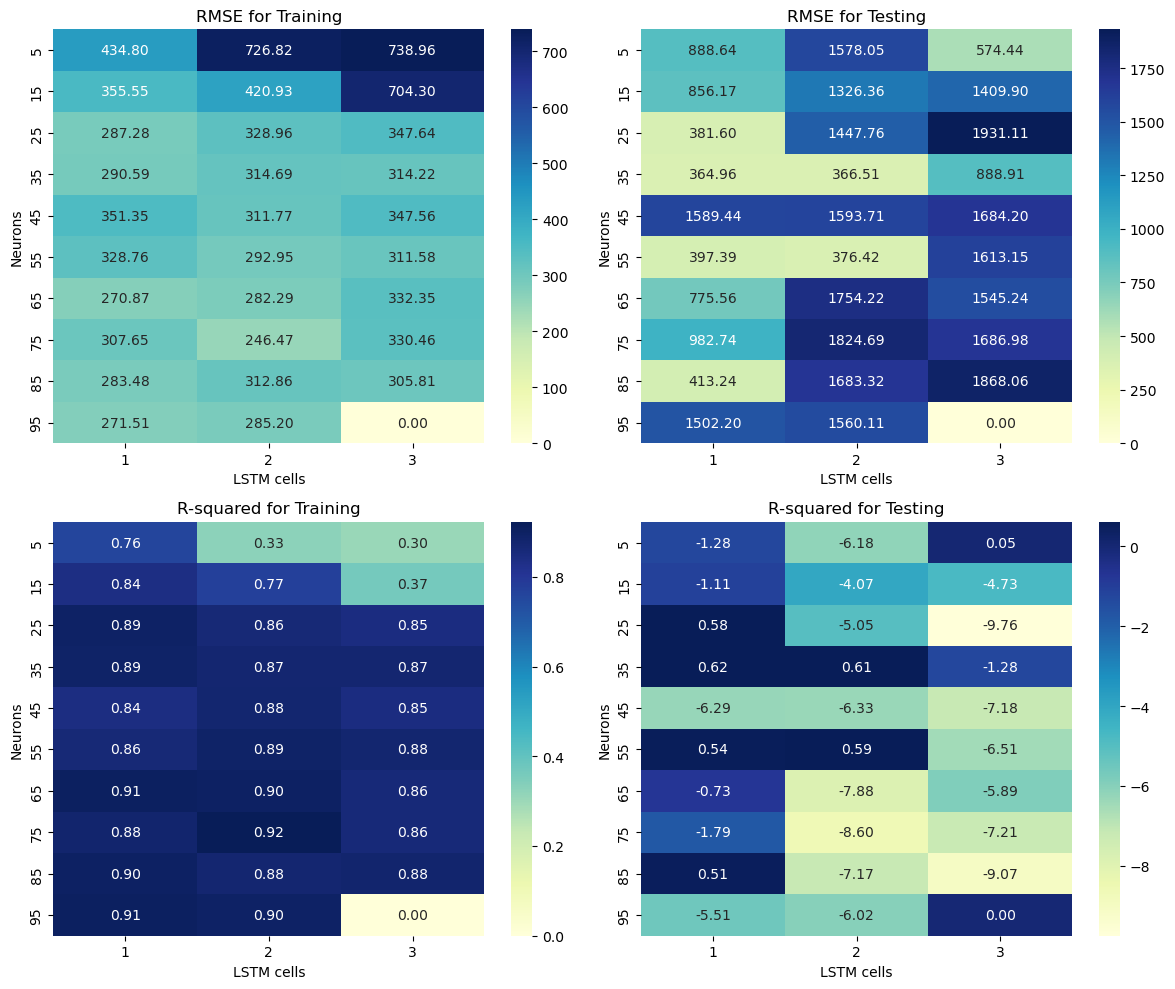

In [44]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Format string for annotations
fmt_str = ".2f"

# Plot MSE for training
sns.heatmap(rmse_train_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('RMSE for Training')
axes[0].set_xlabel('LSTM cells')
axes[0].set_ylabel('Neurons')
axes[0].set_xticks([i + 0.5 for i in range(len(n_layers))])
axes[0].set_yticks([i + 0.5 for i in range(len(hidden_sizes))])
axes[0].set_xticklabels(n_layers)
axes[0].set_yticklabels(hidden_sizes)

# Plot MSE for testing
sns.heatmap(rmse_test_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[1])
axes[1].set_title('RMSE for Testing')
axes[1].set_xlabel('LSTM cells')
axes[1].set_ylabel('Neurons')
axes[1].set_xticks([i + 0.5 for i in range(len(n_layers))])
axes[1].set_yticks([i + 0.5 for i in range(len(hidden_sizes))])
axes[1].set_xticklabels(n_layers)
axes[1].set_yticklabels(hidden_sizes)

# Plot R2 for training
sns.heatmap(r2_train_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[2])
axes[2].set_title('R-squared for Training')
axes[2].set_xlabel('LSTM cells')
axes[2].set_ylabel('Neurons')
axes[2].set_xticks([i + 0.5 for i in range(len(n_layers))])
axes[2].set_yticks([i + 0.5 for i in range(len(hidden_sizes))])
axes[2].set_xticklabels(n_layers)
axes[2].set_yticklabels(hidden_sizes)

# Plot R2 for testing
sns.heatmap(r2_test_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[3])
axes[3].set_title('R-squared for Testing')
axes[3].set_xlabel('LSTM cells')
axes[3].set_ylabel('Neurons')
axes[3].set_xticks([i + 0.5 for i in range(len(n_layers))])
axes[3].set_yticks([i + 0.5 for i in range(len(hidden_sizes))])
axes[3].set_xticklabels(n_layers)
axes[3].set_yticklabels(hidden_sizes)

# Adjust layout
plt.tight_layout()
plt.savefig("cells_neurons")
plt.show()


In [42]:
# Create DataFrame
columns = [f'n_layers={layer}, hidden_size={size}' for layer in hidden_sizes for size in n_layers]
index = [f'hidden_size={size}' for size in hidden_sizes]

# Create a DataFrame with all the lists
combined_df = pd.DataFrame({
    'mse_train': rmse_train_list.flatten(),
    'mse_test': rmse_test_list.flatten(),
    'r2_train': r2_train_list.flatten(),
    'r2_test': r2_test_list.flatten()
}, index=pd.MultiIndex.from_product([hidden_sizes, n_layers], names=['hidden_size', 'n_layers']))
combined_df

mse_train     mse_test  r2_train   r2_test
hidden_size n_layers                                             
5           1         434.798431   888.643381  0.758915 -1.277838
            2         726.819214  1578.046930  0.326330 -6.183028
            3         738.964294   574.440120  0.303628  0.048175
15          1         355.552887   856.167793  0.838786 -1.114392
            2         420.926727  1326.364289  0.774053 -4.074502
            3         704.297974  1409.895154  0.367432 -4.733785
25          1         287.276459   381.599906  0.894757  0.579966
            2         328.962250  1447.760123  0.861998 -5.045900
            3         347.635498  1931.108082  0.845886 -9.756746
35          1         290.594574   364.955668  0.892312  0.615808
            2         314.689636   366.513620  0.873713  0.612521
            3         314.216064   888.912075  0.874093 -1.279215
45          1         351.345367  1589.436870  0.842579 -6.287093
            2         311.770172  1593.714398  0.876045 -6.326368
            3         347.558411  1684.200344  0.845954 -7.181921
55          1         328.759216   397.393423  0.862168  0.544478
            2         292.952362   376.422443  0.890557  0.591287
            3         311.584686  1613.146379  0.876193 -6.506117
65          1         270.865326   775.555808  0.906438 -0.734978
            2         282.290833  1754.224506  0.898378 -7.876425
            3         332.346802  1545.244823  0.859143 -5.887512
75          1         307.648926   982.740790  0.879301 -1.785773
            2         246.465088  1824.685367  0.922535 -8.603814
            3         330.462219  1686.976338  0.860736 -7.208915
85          1         283.479309   413.244755  0.897521  0.507414
            2         312.860138  1683.317456  0.875177 -7.173345
            3         305.813660  1868.060102  0.880736 -9.065827
95          1         271.510254  1502.202192  0.905992 -5.509154
            2         285.196960  1560.110504  0.896275 -6.020669
            3           0.000000     0.000000  0.000000  0.000000

# Final model

In [45]:
n_epochs = 20 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_tensors_final.shape[2] # number of features
hidden_size = 35 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = predicts # number of output classes 

In [46]:
lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              train_loader =train_loader,
              test_loader = test_loader
              )

C:\Users\linag\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01715, test loss: 0.02403
Epoch: 1, train loss: 0.02387, test loss: 0.01966
Epoch: 2, train loss: 0.02540, test loss: 0.01924
Epoch: 3, train loss: 0.02692, test loss: 0.00857
Epoch: 4, train loss: 0.00704, test loss: 0.00902
Epoch: 5, train loss: 0.00767, test loss: 0.00821
Epoch: 6, train loss: 0.01258, test loss: 0.00826
Epoch: 7, train loss: 0.00955, test loss: 0.00964
Epoch: 8, train loss: 0.00935, test loss: 0.00756
Epoch: 9, train loss: 0.00836, test loss: 0.00748
Epoch: 10, train loss: 0.00299, test loss: 0.00743
Epoch: 11, train loss: 0.00859, test loss: 0.00750
Epoch: 12, train loss: 0.01343, test loss: 0.00746
Epoch: 13, train loss: 0.00749, test loss: 0.00669
Epoch: 14, train loss: 0.00929, test loss: 0.00798
Epoch: 15, train loss: 0.00708, test loss: 0.00838
Epoch: 16, train loss: 0.00394, test loss: 0.01481
Epoch: 17, train loss: 0.00564, test loss: 0.01039
Epoch: 18, train loss: 0.00958, test loss: 0.

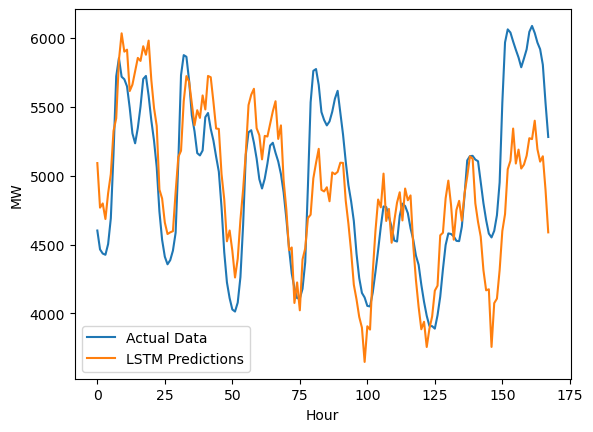

In [47]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.ylabel('MW')
plt.xlabel('Hour')
plt.legend()
plt.savefig('True_vs_predicted.png')
plt.show()